In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv("../../../data/raw/BankChurners.csv")

In [30]:
# Remove leakage + ID
df = df.drop([
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
], axis=1)

# Feature engineering
df['avg_spend_per_txn'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df['credit_used_ratio'] = df['Total_Revolving_Bal'] / df['Credit_Limit']
df['tenure_years'] = df['Months_on_book'] / 12

df['low_txn_flag'] = (df['Total_Trans_Ct'] < 50).astype(int)
df['high_inactive_flag'] = (df['Months_Inactive_12_mon'] >= 3).astype(int)
df['high_contact_flag'] = (df['Contacts_Count_12_mon'] >= 3).astype(int)

In [31]:
cluster_features = [
    'Customer_Age',
    'Credit_Limit',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Revolving_Bal',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Total_Relationship_Count',
    'Avg_Utilization_Ratio',
    'avg_spend_per_txn',
    'credit_used_ratio',
    'tenure_years'
]

X_cluster = df[cluster_features]

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


## Elbow method clustering

In [33]:
##elbow curve
from sklearn.cluster import KMeans

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

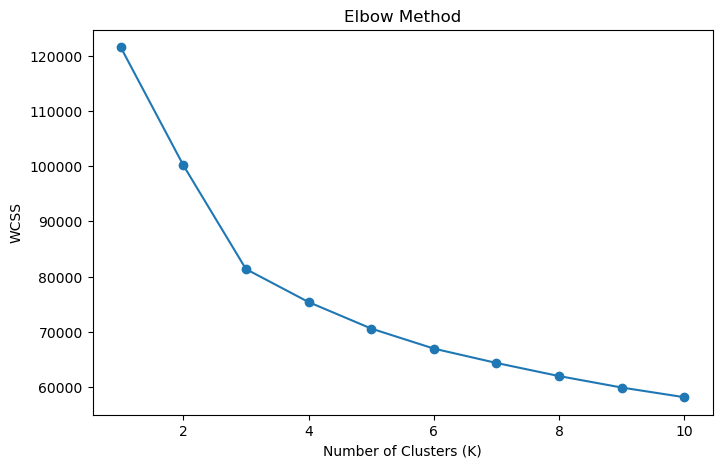

In [34]:
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [35]:
## k=3

In [36]:
## fitting k means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

In [37]:
cluster_profile = df.groupby('cluster')[cluster_features].mean().round(2)
cluster_profile

,Customer_Age,Credit_Limit,Total_Trans_Amt,Total_Trans_Ct,Total_Revolving_Bal,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Relationship_Count,Avg_Utilization_Ratio,avg_spend_per_txn,credit_used_ratio,tenure_years
cluster,,,,,,,,,,,,
0,46.46,10910.56,3070.12,57.11,747.13,2.37,2.58,4.06,0.08,53.05,0.08,3.01
1,46.44,3105.65,3550.12,63.26,1682.22,2.32,2.37,4.04,0.59,55.17,0.59,2.99
2,45.49,15171.53,11770.23,98.42,1307.79,2.26,2.24,2.23,0.15,119.05,0.15,2.93


In [38]:
## labeling these segmentation
segment_map = {
    0: "Low Engagement Users",
    1: "Credit Revolvers",
    2: "High Value Spenders"
}

df['segment'] = df['cluster'].map(segment_map)

In [39]:
"""
Customer Segments Identified:

1. Low Engagement Users:
   Low transactions, low spending, low utilization.
   Likely to churn → need activation campaigns.

2. Credit Revolvers:
   High credit utilization and revolving balance.
   Valuable customers → focus on retention and loyalty rewards.

3. High Value Spenders:
   High spend and transaction volume with high credit limits.
   Premium segment → focus on upselling and exclusive offers.
"""


'\nCustomer Segments Identified:\n\n1. Low Engagement Users:\n   Low transactions, low spending, low utilization.\n   Likely to churn → need activation campaigns.\n\n2. Credit Revolvers:\n   High credit utilization and revolving balance.\n   Valuable customers → focus on retention and loyalty rewards.\n\n3. High Value Spenders:\n   High spend and transaction volume with high credit limits.\n   Premium segment → focus on upselling and exclusive offers.\n'

In [40]:
import joblib

joblib.dump(kmeans, "../../../data/processed/kmeans_model.pkl")

['../../../data/processed/kmeans_model.pkl']

## Now- merging churn and segmentation!

In [41]:
df_processed = pd.read_csv("../../../data/processed/full_processed_data.csv")


In [42]:
import joblib
churn_model = joblib.load("../../../data/processed/churn_model.pkl")

X_all = df_processed.drop('churn', axis=1)

df_processed['churn_probability'] = churn_model.predict_proba(X_all)[:,1]

In [43]:
df['churn_probability'] = df_processed['churn_probability']

In [44]:
def risk_level(p):
    if p >= 0.7:
        return "High Risk"
    elif p >= 0.3:
        return "Medium Risk"
    else:
        return "Low Risk"

df['risk_level'] = df['churn_probability'].apply(risk_level)


## business table

In [45]:
risk_segment_table = pd.crosstab(
    df['segment'],
    df['risk_level'],
    normalize='index'
) * 100

risk_segment_table.round(2)


risk_level,Low Risk,Medium Risk
segment,,
Credit Revolvers,96.48,3.52
High Value Spenders,98.44,1.56
Low Engagement Users,97.29,2.71


In [46]:
df['churn_probability'].describe()

count    10127.000000
mean         0.075997
std          0.084751
min          0.002561
25%          0.025924
50%          0.048615
75%          0.081818
max          0.648984
Name: churn_probability, dtype: float64

In [47]:
high_cutoff = df['churn_probability'].quantile(0.90)
medium_cutoff = df['churn_probability'].quantile(0.70)

def risk_level_quantile(p):
    if p >= high_cutoff:
        return "High Risk"
    elif p >= medium_cutoff:
        return "Medium Risk"
    else:
        return "Low Risk"

df['risk_level'] = df['churn_probability'].apply(risk_level_quantile)


In [48]:
pd.crosstab(df['segment'], df['risk_level'], normalize='index') * 100


risk_level,High Risk,Low Risk,Medium Risk
segment,,,
Credit Revolvers,11.779041,65.285676,22.935283
High Value Spenders,5.114900,82.802076,12.083024
Low Engagement Users,10.009833,69.990167,20.000000


In [49]:
"""
Customer Intelligence Table Created

By combining segmentation and churn prediction we created
actionable customer groups:

• Credit Revolvers → high-value but high churn risk
• High Value Spenders → premium customers needing VIP retention
• Low Engagement Users → reactivation targets

This table will power the personalized reward recommender.
"""


'\nCustomer Intelligence Table Created\n\nBy combining segmentation and churn prediction we created\nactionable customer groups:\n\n• Credit Revolvers → high-value but high churn risk\n• High Value Spenders → premium customers needing VIP retention\n• Low Engagement Users → reactivation targets\n\nThis table will power the personalized reward recommender.\n'

In [51]:
customer_intelligence = df[[
    'segment',
    'churn_probability',
    'risk_level',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Avg_Utilization_Ratio',
    'Total_Relationship_Count'
]].copy()

customer_intelligence.to_csv(
    "../../../data/processed/customer_intelligence.csv",
    index=False
)
